In [ ]:
# ADDITIONAL NOTES:

'''Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month.
Supermarket sales could be affected by this. A magnitude 7.8 earthquake struck Ecuador on
* Can add in some features to help the model learn this pattern

April 16, 2016. People rallied in relief efforts donating water and other first need products which
greatly affected supermarket sales for several weeks after the earthquake.
* Might be worth omitting this period from the training set
'''

In [2]:
from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px

In [19]:
df_train = pd.read_csv(join('data', 'train.csv'))
df_oil = pd.read_csv(join('data', 'oil.csv')).set_index('date')
df_transactions = pd.read_csv(join('data', 'transactions.csv')).set_index('date')

df_stores = pd.read_csv(join('data', 'stores.csv'))

df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.merge(df_stores[['store_nbr', 'cluster']], on='store_nbr', how='left')

df_train['date'] = pd.to_datetime(df_train['date'])
df_oil.index = pd.to_datetime(df_oil.index)
df_transactions.index = pd.to_datetime(df_transactions.index)
#for series in (df_train['date'], df_oil.index, df_transactions.index):
#    series = pd.to_datetime(series)

In [20]:
df_oil.head()

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20

In [21]:
df = pd.merge(df_train, df_oil, how='left', left_on='date', right_on='date')
df = pd.merge(df, df_transactions, how='left', on=['date', 'store_nbr'])

df = df.rename(columns={'transactions': 'daily_store_transactions'})

In [22]:
df.tail()

id       date  store_nbr                      family     sales  \
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  cluster  dcoilwtico  daily_store_transactions  
3000883            0        6       47.57                    2155.0  
3000884            1        6       47.57                    2155.0  
3000885          148        6       47.57                    2155.0  
3000886            8        6       47.57                    2155.0  
3000887            0        6       47.57                    2155.0

In [23]:
# What are the categories?
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [24]:
# Let's see the total and average sales by category
#total_sales_by_category = df.groupby('family')['sales'].sum().reset_index()
mean_sales_by_category = df.groupby('family')['sales'].mean().reset_index()

#print(total_sales_by_category)
print(mean_sales_by_category)

                        family        sales
0                   AUTOMOTIVE     6.101236
1                    BABY CARE     0.110528
2                       BEAUTY     3.715723
3                    BEVERAGES  2385.793151
4                        BOOKS     0.070797
5                 BREAD/BAKERY   463.336254
6                  CELEBRATION     8.370469
7                     CLEANING  1072.416744
8                        DAIRY   709.154889
9                         DELI   265.135067
10                        EGGS   171.420516
11                FROZEN FOODS   154.766954
12                   GROCERY I  3776.972100
13                  GROCERY II    21.584048
14                    HARDWARE     1.137833
15          HOME AND KITCHEN I    20.470342
16         HOME AND KITCHEN II    16.722420
17             HOME APPLIANCES     0.457476
18                   HOME CARE   176.198029
19                  LADIESWEAR     7.160629
20             LAWN AND GARDEN     6.035475
21                    LINGERIE  

In [29]:
df_beverages = df[df['family'] == 'BEVERAGES']

In [30]:
# Plot the first store's sales
df_beverages_store_1 = df_beverages[(df_beverages['store_nbr'] == 1)]

In [31]:
df_beverages.head()

id       date  store_nbr     family  sales  onpromotion  cluster  \
3      3 2013-01-01          1  BEVERAGES    0.0            0       13   
36    36 2013-01-01         10  BEVERAGES    0.0            0       15   
69    69 2013-01-01         11  BEVERAGES    0.0            0        6   
102  102 2013-01-01         12  BEVERAGES    0.0            0       15   
135  135 2013-01-01         13  BEVERAGES    0.0            0       15   

     dcoilwtico  daily_store_transactions  
3           NaN                       NaN  
36          NaN                       NaN  
69          NaN                       NaN  
102         NaN                       NaN  
135         NaN                       NaN

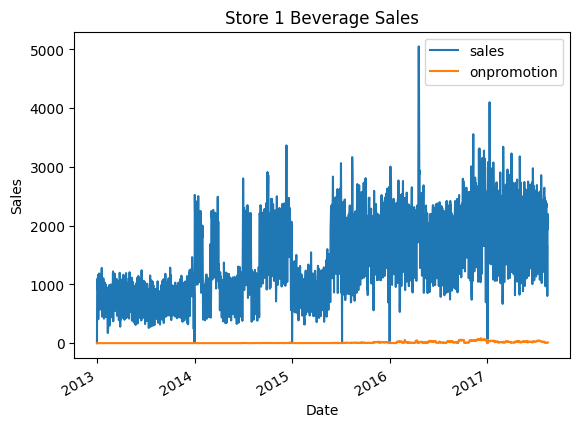

In [64]:
import matplotlib.pyplot as plt

# Scale up onpromotion to see if it overlaps with sales peaks
#df_beverages_store_1['onpromotion'] = df_beverages_store_1['onpromotion'] * 100#df_beverages_store_1['sales'].max()

df_beverages_store_1.plot(x='date', y=['sales', 'onpromotion'], kind='line')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Store 1 Beverage Sales')
plt.show()

In [58]:
# The on promotion seems to be a non-binary value that maybe indicates the fraction of beverages 
# that are on promotion.

In [33]:
import statsmodels.api as sm
# See if lagged values might have some predictive power by plotting lag-n autocorrelation
lags = 10

# Plot ACF
#sm.graphics.tsa.plot_acf(df['sales'].values.squeeze(), lags=lags, title='Sales Autocorrelation')
#plt.show()

# Plot PACF
#sm.graphics.tsa.plot_pacf(df['sales'].values.squeeze(), lags=lags, method='ywm', title=f'Sales Partial Autocorrelation')
#plt.show()

In [34]:
# Compare correlation of beverage sales across stores
df_beverage = df[df['family'] == 'BEVERAGES']

#df_baby_care_pivoted = df_baby_care.pivot(columns='store_nbr', values='sales')
#df_baby_care = df_baby_care.drop(['family'])

df_pivot = df_beverage.pivot(index=['date', 'dcoilwtico'], columns='store_nbr', values='sales')
df_pivot.reset_index(inplace=True)

# Change the column name from indices to string
df_pivot = df_pivot.rename(columns=lambda x: f'store_{x}' if isinstance(x, int) else x)

In [35]:
df_pivot.head()
#df_baby_care.head()

store_nbr       date  dcoilwtico  store_1  store_2  store_3  store_4  store_5  \
0         2013-01-01         NaN      0.0      0.0      0.0      0.0      0.0   
1         2013-01-02       93.14   1091.0   1481.0   4486.0   1545.0    947.0   
2         2013-01-03       92.97    919.0   1016.0   3367.0   1020.0    847.0   
3         2013-01-04       93.12    953.0   1146.0   3283.0    944.0    859.0   
4         2013-01-05         NaN   1160.0   1581.0   4886.0   1551.0    912.0   

store_nbr  store_6  store_7  store_8  ...  store_45  store_46  store_47  \
0              0.0      0.0      0.0  ...       0.0       0.0       0.0   
1           1693.0   2277.0   2424.0  ...    4070.0    3459.0    3840.0   
2           1227.0   1531.0   1985.0  ...    2526.0    1806.0    2624.0   
3           1156.0   1355.0   1803.0  ...    3064.0    2095.0    2912.0   
4           1898.0   1828.0   2968.0  ...    4852.0    3703.0    4402.0   

store_nbr  store_48  store_49  store_50  store_51  store_52  store_53  \
0               0.0       0.0       0.0       0.0       0.0       0.0   
1            1966.0    3133.0    1794.0    3181.0       0.0       0.0   
2            1359.0    1829.0    1324.0    2192.0       0.0       0.0   
3            1446.0    1911.0    1243.0    2734.0       0.0       0.0   
4            2686.0    3035.0    2105.0    3361.0       0.0       0.0   

store_nbr  store_54  
0               0.0  
1             597.0  
2             422.0  
3             325.0  
4             414.0  

[5 rows x 56 columns]

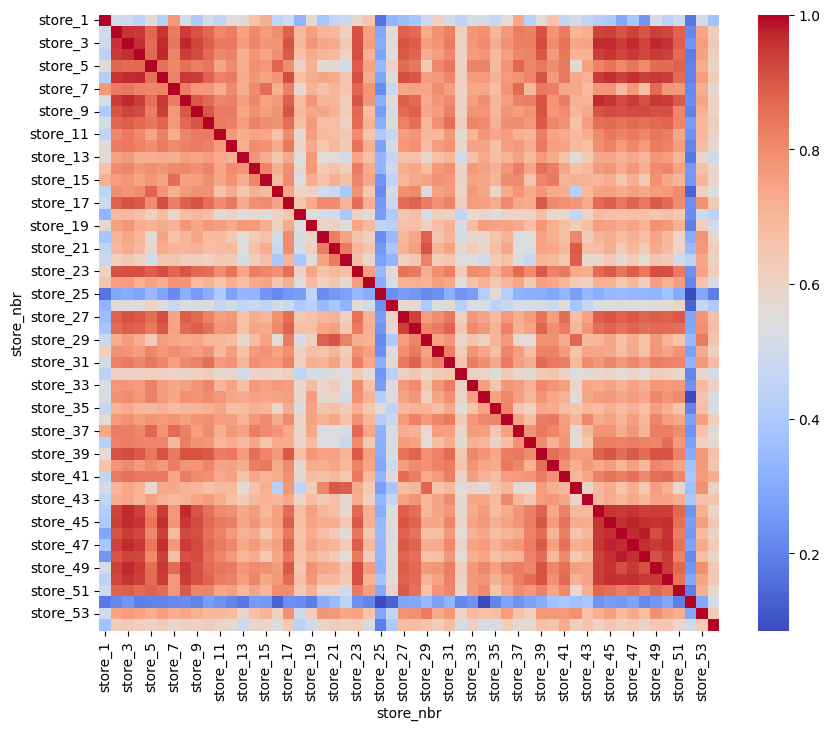

In [36]:
import seaborn as sns

# Are sales of the same product in different stores correlated?
# Create a correlation matrix for all features and target
corr_matrix = df_pivot.drop(columns=['date', 'dcoilwtico']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

Some stores such as 1, 25, 26 and 52 appear to be total outliers, while the majority of the stores' sales figures are happily very highly correlated with each other. Since beverage sales figures are rather high on average across stores, this correlation is also not likely due to zero sales.
Stores 44-50 seem to form a very strong cluster so let's plot their sales figures on the same axes
for comparison.

In [37]:
# In the dataset the stores have been assigned to one of 17 clusters (presumably algorithmically
# based on some set of features), but I'm not sure how they arrived at these. In future should I
# decide to partition the data, it might be worth creating my own clusters specifically for beverage
# sales (e.g. extract many features from the time series, perform dimensionality reduction through
# PCA or t-SNE (probably the latter as it better maintains distance between nearby points in lower
# dimensional space) and perform k-means to get my own set of clusters for the time series)
df_stores.sort_values(by='store_nbr')


store_nbr           city                           state type  cluster
0           1          Quito                       Pichincha    D       13
1           2          Quito                       Pichincha    D       13
2           3          Quito                       Pichincha    D        8
3           4          Quito                       Pichincha    D        9
4           5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
5           6          Quito                       Pichincha    D       13
6           7          Quito                       Pichincha    D        8
7           8          Quito                       Pichincha    D        8
8           9          Quito                       Pichincha    B        6
9          10          Quito                       Pichincha    C       15
10         11        Cayambe                       Pichincha    B        6
11         12      Latacunga                        Cotopaxi    C       15
12         13      Latacunga                        Cotopaxi    C       15
13         14       Riobamba                      Chimborazo    C        7
14         15         Ibarra                        Imbabura    C       15
15         16  Santo Domingo  Santo Domingo de los Tsachilas    C        3
16         17          Quito                       Pichincha    C       12
17         18          Quito                       Pichincha    B       16
18         19       Guaranda                         Bolivar    C       15
19         20          Quito                       Pichincha    B        6
20         21  Santo Domingo  Santo Domingo de los Tsachilas    B        6
21         22           Puyo                         Pastaza    C        7
22         23         Ambato                      Tungurahua    D        9
23         24      Guayaquil                          Guayas    D        1
24         25        Salinas                     Santa Elena    D        1
25         26      Guayaquil                          Guayas    D       10
26         27          Daule                          Guayas    D        1
27         28      Guayaquil                          Guayas    E       10
28         29      Guayaquil                          Guayas    E       10
29         30      Guayaquil                          Guayas    C        3
30         31       Babahoyo                        Los Rios    B       10
31         32      Guayaquil                          Guayas    C        3
32         33        Quevedo                        Los Rios    C        3
33         34      Guayaquil                          Guayas    B        6
34         35         Playas                          Guayas    C        3
35         36       Libertad                          Guayas    E       10
36         37         Cuenca                           Azuay    D        2
37         38           Loja                            Loja    D        4
38         39         Cuenca                           Azuay    B        6
39         40        Machala                          El Oro    C        3
40         41        Machala                          El Oro    D        4
41         42         Cuenca                           Azuay    D        2
42         43     Esmeraldas                      Esmeraldas    E       10
43         44          Quito                       Pichincha    A        5
44         45          Quito                       Pichincha    A       11
45         46          Quito                       Pichincha    A       14
46         47          Quito                       Pichincha    A       14
47         48          Quito                       Pichincha    A       14
48         49          Quito                       Pichincha    A       11
49         50         Ambato                      Tungurahua    A       14
50         51      Guayaquil                          Guayas    A       17
51         52          Manta                          Manabi    A       11
52         53          Manta 

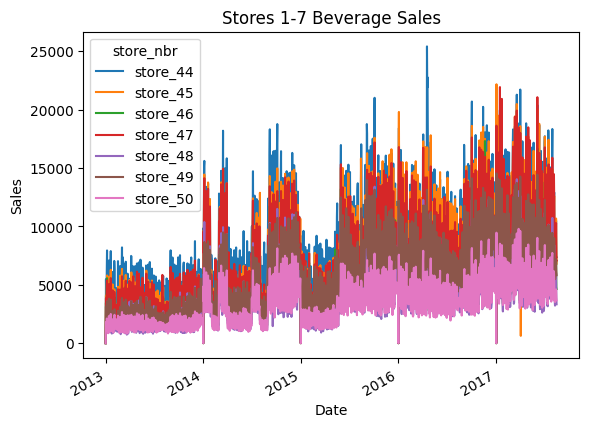

In [38]:
# Some stores such as 32, 43 and 52 appear to be total outliers, while some stores' sales figures are
# very highly correlated with each other, but this might just be because all the values are zero.
# Stores 1-7 seem to form a very strong cluster so let's plot their sales figures on the same axes
# for comparison
df_pivot.plot(x='date', y=[f'store_{x}' for x in range(44, 51)], kind='line')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Stores 1-7 Beverage Sales')
plt.show()

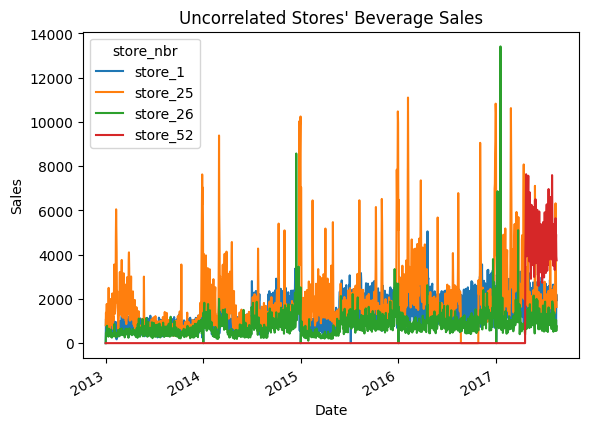

In [66]:
# Let's plot the three stores that correlated poorly with the rest to see
# if anything jumps out
df_pivot.plot(x='date', y=[f'store_{x}' for x in [1, 25, 26, 52]], kind='line')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Uncorrelated Stores\' Beverage Sales')
plt.show()

Store 52 opened recently which explains that. For the other three it's less
obvious what the cause of the weaker correlation might be.

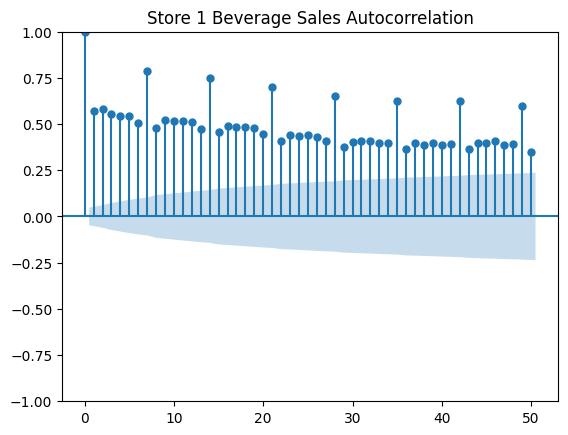

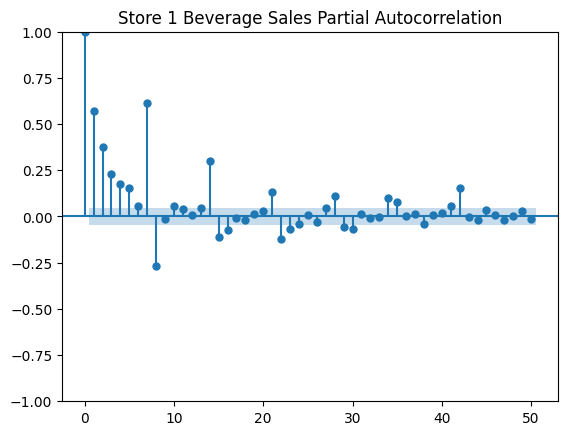

In [39]:
# TODO: Plot the correlation between lagged values of these exogeneous variables and beverage sales
import statsmodels.api as sm
# See if lagged values might have some predictive power by plotting lag-n autocorrelation
lags = 50

# Plot ACF
sm.graphics.tsa.plot_acf(df_pivot['store_1'], lags=lags, title=f'Store 1 Beverage Sales Autocorrelation')
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df_pivot['store_1'], lags=lags, title=f'Store 1 Beverage Sales Partial Autocorrelation')
plt.show()

In [55]:
a = df_beverage.copy()
a["year"] = a['date'].dt.year
a["month"] = a['date'].dt.month
px.box(a, x="year", y="sales" , color = "month", title = "All Sales")

In [59]:
a = df_beverage[df_beverage['date'].dt.year == 2017].copy()
a["day"] = a['date'].dt.day_of_week
px.box(a, x="day", y="sales", title = "Beverage Sales by Day of Week")

There appear to be more beverage sales friday-sunday with fewer in the week, with the fewest sales on wednesday.

So there is some strong correlation in beverage sales across different stores, and looking at the
pacf chart it seems as though fitting a simple autoregressive model might enable us to predict with
some accuracy what future sales values may be. There is also seemingly some weekly seasonality for
beverage sales.

Even better might be to add more embedded time series features to capture seasonality, as well as
including information about holiday events and the price of oil, which were also included in the
dataset.

Let's investigate their impact on beverage sales.

In [40]:
# Add oil price lags
num_lags = 3

for lag in range(1, num_lags):
    df_pivot[f'dcoilwtico_lag_{lag}'] = df_pivot['dcoilwtico'].shift(lag)

In [41]:
df_pivot.head()

store_nbr       date  dcoilwtico  store_1  store_2  store_3  store_4  store_5  \
0         2013-01-01         NaN      0.0      0.0      0.0      0.0      0.0   
1         2013-01-02       93.14   1091.0   1481.0   4486.0   1545.0    947.0   
2         2013-01-03       92.97    919.0   1016.0   3367.0   1020.0    847.0   
3         2013-01-04       93.12    953.0   1146.0   3283.0    944.0    859.0   
4         2013-01-05         NaN   1160.0   1581.0   4886.0   1551.0    912.0   

store_nbr  store_6  store_7  store_8  ...  store_47  store_48  store_49  \
0              0.0      0.0      0.0  ...       0.0       0.0       0.0   
1           1693.0   2277.0   2424.0  ...    3840.0    1966.0    3133.0   
2           1227.0   1531.0   1985.0  ...    2624.0    1359.0    1829.0   
3           1156.0   1355.0   1803.0  ...    2912.0    1446.0    1911.0   
4           1898.0   1828.0   2968.0  ...    4402.0    2686.0    3035.0   

store_nbr  store_50  store_51  store_52  store_53  store_54  dcoilwtico_lag_1  \
0               0.0       0.0       0.0       0.0       0.0               NaN   
1            1794.0    3181.0       0.0       0.0     597.0               NaN   
2            1324.0    2192.0       0.0       0.0     422.0             93.14   
3            1243.0    2734.0       0.0       0.0     325.0             92.97   
4            2105.0    3361.0       0.0       0.0     414.0             93.12   

store_nbr  dcoilwtico_lag_2  
0                       NaN  
1                       NaN  
2                       NaN  
3                     93.14  
4                     92.97  

[5 rows x 58 columns]

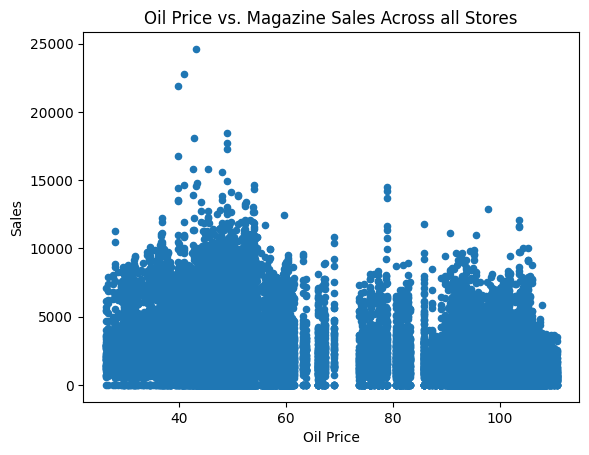

In [43]:
# TODO: Plot the correlation between oil price / holiday events and beverage sales across all
# stores
#df_pivot.plot(x='dcoilwtico', y='store_3', kind='scatter')
df_beverage.plot(x='dcoilwtico', y='sales', kind='scatter')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Oil Price vs. Beverage Sales Across all Stores')
plt.show()

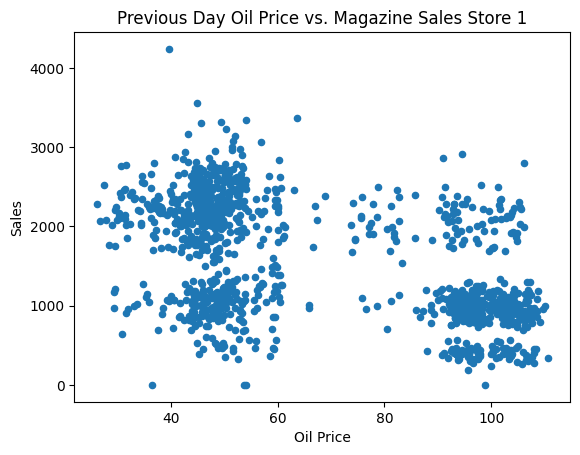

In [44]:
# Plot the correlation between d-2 oil price and beverage sales for a given store on day d
df_pivot.plot(x='dcoilwtico_lag_2', y='store_1', kind='scatter')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Previous Day Oil Price vs. Beverage Sales Store 1')
plt.show()

The price of oil appears to have a slight negative correlation with beverage
sales, but unlike some other products (beverage sales experienced a step change around 60
dollars per barrel), beverage sales appear to be more resistant to changes in oil price (a strong
indicator of the regional economic climate). It doesn't look like features derived from the price
of oil will be hugely useful when predicting future beverage sales, but they still may have some
value

In [45]:
oil_values = df_oil['dcoilwtico'].values.squeeze()

# How many nan are present?
num_nan = np.count_nonzero(np.isnan(oil_values))

print(num_nan)
print(f'{num_nan/len(oil_values)*100:.2f}% of values are NaN')

43
3.53% of values are NaN


In [46]:
# Since there aren't too many nan I'll just remove them to get a view of the autocorrelation
oil_values_cleaned = oil_values[~np.isnan(oil_values)]

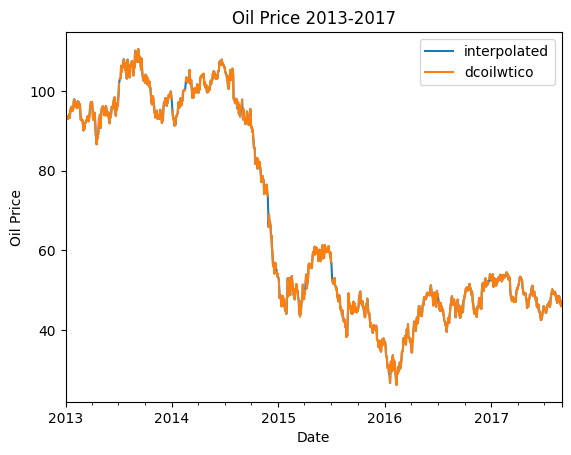

In [47]:
df_oil['date'] = df_oil.index

df_oil_temp = df_oil.copy()
df_oil_temp['interpolated'] = df_oil_temp['dcoilwtico'].interpolate(method='linear')

# Plot the oil values from 2013-2017
df_oil_temp.plot(x='date', y=['interpolated', 'dcoilwtico'], kind='line')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Price 2013-2017')
plt.show()

In [48]:
# Using linear interpolation seems to be okay at the macro level, but an unusual change in value over
# the last few iterations could potentially have an impact on model output.

# At least for now I think this is fine, as the price of oil seems to have more of a step impact on
# beverage purchasing behaviour as shown above, so this is not likely to matter.

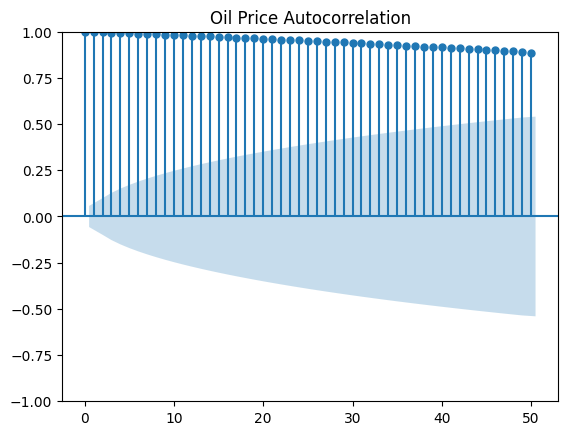

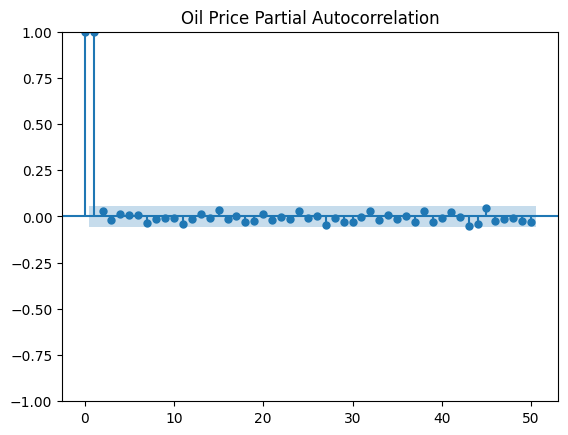

In [60]:
# Oil prices typically display some level of autocorrelation, and the above relationship between
# d-n oil prices and beverage sales on day d would seem to suggest this, but let's again plot a
# pacf chart to see how strong the relationship is

# TODO: Plot the correlation between lagged values of these exogeneous variables and beverage sales
import statsmodels.api as sm
# See if lagged values might have some predictive power by plotting lag-n autocorrelation
lags = 50

# Plot ACF
sm.graphics.tsa.plot_acf(oil_values_cleaned, lags=lags, title=f'Oil Price Autocorrelation')
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(oil_values_cleaned, lags=lags, method='ywm', title=f'Oil Price Partial Autocorrelation')
plt.show()

Since the ACF is highly autocorrelated over a long time period, it suggests the price of gas
is highly influenced by previous prices of gas.

However, in the PACF (which removes the effects of intermediate lags).

It is quite hard to distinguish between a random walk and an AR(1) model, as t is highly correlated with t-1 only in both cases. However, some online research suggests that a random walk ACF decays slowly and in a linear fashion, whereas an AR(1) model decays exponentially.
This suggests that oil price is essentially a random walk, but knowing today's oil price may
still be a useful input if it has an impact on economic behaviour.

Taking the natural log of the oil price and differencing gives
a stationary time series. If it is white noise then oil price
can be assumed to be a random walk and is not forecastible

In [75]:
df_oil_temp['log'] = np.log(df_oil_temp['interpolated'])
df_oil_temp['diff_log'] = df_oil_temp['log'].diff()

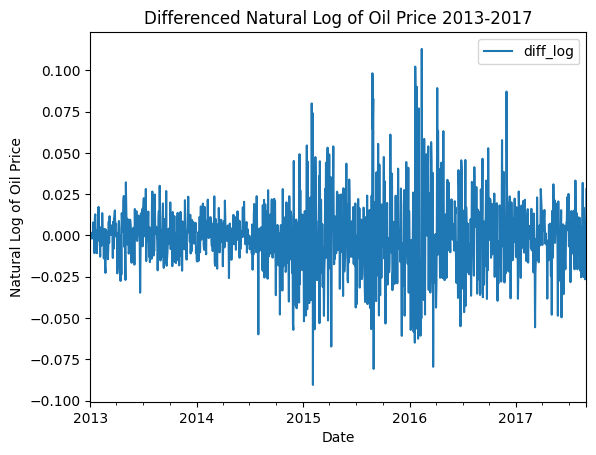

In [77]:
# Plot the oil values from 2013-2017
df_oil_temp.plot(x='date', y=['diff_log'], kind='line')
plt.xlabel('Date')
plt.ylabel('Natural Log of Oil Price')
plt.title('Differenced Natural Log of Oil Price 2013-2017')
plt.show()

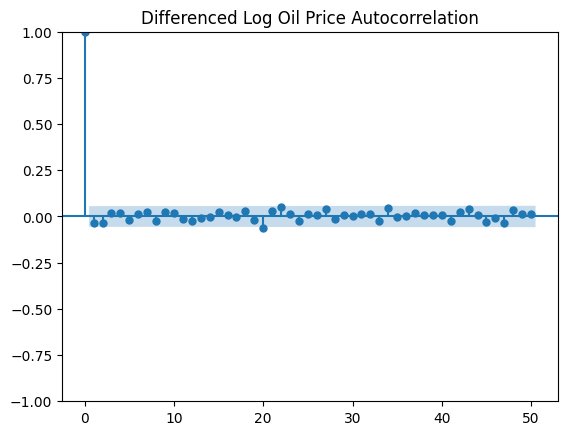

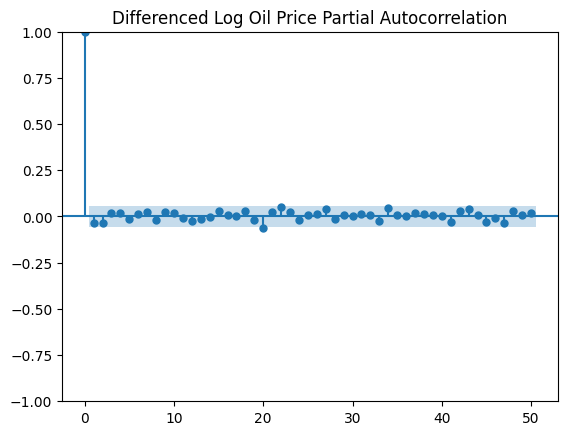

In [83]:
# Plot ACF
sm.graphics.tsa.plot_acf(df_oil_temp['diff_log'].dropna(), lags=lags, title=f'Differenced Log Oil Price Autocorrelation')
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df_oil_temp['diff_log'].dropna(), lags=lags, method='ywm', title=f'Differenced Log Oil Price Partial Autocorrelation')
plt.show()

This seems to confirm the oil price = random walk theory, but that's
not really an issue as we're not trying to predict oil price.

In [62]:
df_transactions.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-02', '2013-01-02',
               '2013-01-02', '2013-01-02', '2013-01-02', '2013-01-02',
               '2013-01-02', '2013-01-02',
               ...
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=83488, freq=None)

In [63]:
# Now let's explore some patterns in the transaction data

a = df_transactions.copy()
a["year"] = a.index.year
a["month"] = a.index.month
px.box(a, x="year", y="transactions" , color = "month", title = "All Transactions")

In [ ]:
# So it seems as though transactions are similar throughout the year before spiking in december,
# and this stayed constant from 2013-2017

In [74]:
# The dataset seems to be a good fit for a global forecasting model that can be trained once and
# use the sales data from other stores to make predictions for future sales, although the dataset
# for a single product's sales is quite sparse. One way to overcome this sparsity might be to partition
# the dataset (either algorithmically through a combination of pca/t-SNE on a rich, high-dimensional set
# of extracted time-series features to reduce dimensionality, and then performing k-means) or by simply
# using the clusters pre-provided in the dataset.

# A first step might be to plot which cluster each store has been assigned to and compare how this
# overlaps with the correlation matrix shown above.